In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy


from sklearn.ensemble import RandomForestClassifier
from sklearn import clone
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import nltk
import gensim


In [2]:
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial import distance
from scipy.cluster.hierarchy import cophenet

In [5]:
#Functions for fitting random forest model
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for i, col in enumerate(X_train.columns):
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


def get_predictive_terms(df, bin_data, features, route, n):
    is_route = df.Route == route
    positive = bin_data[is_route]
    _negative = bin_data[~is_route]
    size = positive.shape[0]
    y=[1]*size + [0]*size
    print(route, "-->", size)
    
    importances = []
    for i in range(0, n):
        random_idx = np.random.choice(_negative.shape[0], size=size, replace=False)
        negative = _negative[random_idx]
        X=np.vstack([positive, negative])
        rf = RandomForestClassifier(max_depth=3, n_estimators=100, oob_score=True)
        rf.fit(X, y)

        # Build dataframe only with used columns
        X_train = pd.DataFrame(X, columns=features)
        drop_cols = X_train.columns[rf.feature_importances_ == 0.0]
        X_train.drop(drop_cols, axis=1, inplace=True)
        
        I = dropcol_importances(rf, X_train, y)
        importances.append(I)
        
    df_imp = pd.concat(importances, axis=1, sort=False)
    df_imp[pd.isnull(df_imp)] = 0.0
    
    keywords_mean = df_imp.apply(np.mean, axis=1).sort_values(ascending=False)
    return dict(keywords_mean[keywords_mean > 0]), dict(keywords_mean[keywords_mean == 0])

In [10]:
#Functions for identifying terms with highest tf-idf
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding 
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important 
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def get_top_words(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words['feature'].values

In [11]:
def get_top_words_weights(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words

In [13]:
output_dir = '/Users/jdjumalieva/ESCoE/outputs/'

In [14]:
lookup_dir = '/Users/jdjumalieva/ESCoE/lookups/'

In [15]:
model = gensim.models.KeyedVectors.load_word2vec_format\
(os.path.join(lookup_dir, 'word2vec_output.txt'))

In [15]:
df_api = pd.read_csv(os.path.join(output_dir, 'df_api.csv'),
                     encoding = 'utf-8')

In [16]:
df_api.head()

,ApprovedForDelivery,AssessmentPlanUrl,Category,CreatedDate,Duration,EntryRequirements,ID,IsPublished,JobRoles,Keywords,...,StandardInformation,StandardPageUri,Status,Title,TypicalLength,Uri,Version,WhatApprenticesWillLearn,clean_standard_info,clean_desc
0,2019-04-12T00:00:00,/media/2916/st0535_clinical-coder_l3_ap-final-...,Health and science,2017-11-14T17:09:43,18,NaN,444,True,[],[],...,<h3>Occupational profile</h3>\n<p>Clinical cod...,/apprenticeship-standards/clinical-coder/,Approved for delivery,Clinical coder,"{'From': 18, 'To': 18, 'Unit': 'm'}",https://www.instituteforapprenticeships.org/ap...,1.0,NaN,Occupational profile\nClinical coding is the p...,occupational profile clinical coding is the pr...
1,2019-04-12T00:00:00,/media/2915/st0559_museum-galleries-technician...,Creative and design,2017-11-14T17:09:01,15,NaN,443,True,"['Exhibition Technician', 'Curatorial Assistan...",[],...,<h3><strong>Profile</strong></h3>\n<p>A Museum...,/apprenticeship-standards/museums-and-gallerie...,Approved for delivery,Museums and galleries technician,"{'From': 15, 'To': 15, 'Unit': 'm'}",https://www.instituteforapprenticeships.org/ap...,1.0,NaN,Profile\nA Museum and Gallery Technician creat...,profile a museum and gallery technician create...
2,2019-04-11T00:00:00,/media/2914/st0696-post-production-technical-o...,Creative and design,2018-03-12T09:27:53,12,NaN,442,True,"['Technical Operator', 'MCR Operator', 'Grade/...",[],...,<h3>Occupation summary</h3>\n<p>This occupatio...,/apprenticeship-standards/post-production-tech...,Approved for delivery,Post production technical operator,"{'From': 12, 'To': 12, 'Unit': 'm'}",https://www.instituteforapprenticeships.org/ap...,1.0,NaN,Occupation summary\nThis occupation is found i...,occupation summary this occupation is found in...
3,2019-04-11T00:00:00,/media/2911/st0749_historic_environment_advice...,Creative and design,2018-05-30T14:21:16,24,NaN,441,True,"['Heritage at Risk Projects Officer', 'Built H...",[],...,<h3> </h3>\n<h3>Occupation summary</h3>\n<p>Th...,/apprenticeship-standards/historic-environment...,Approved for delivery,Historic environment advice assistant,"{'From': 24, 'To': 24, 'Unit': 'm'}",https://www.instituteforapprenticeships.org/ap...,1.0,NaN,\nOccupation summary\nThis occupation is foun...,occupation summary this occupation is found in...
4,2019-04-11T00:00:00,/media/2910/20190408-st0617_facilities_service...,Construction,2017-11-14T17:09:48,12,NaN,440,True,"['Facilities Services Operative', 'Facilities ...",[],...,<h3>Occupation summary</h3>\n<p>This occupatio...,/apprenticeship-standards/facilities-services-...,Approved for delivery,Facilities services operative,"{'From': 12, 'To': 12, 'Unit': 'm'}",https://www.instituteforapprenticeships.org/ap...,1.0,NaN,Occupation summary\nThis occupation is found i...,occupation summary this occupation is found in...


In [17]:
df_api.columns

Index(['ApprovedForDelivery', 'AssessmentPlanUrl', 'Category', 'CreatedDate',
       'Duration', 'EntryRequirements', 'ID', 'IsPublished', 'JobRoles',
       'Keywords', 'LastUpdated', 'Level', 'MaxFunding',
       'OccupationalStandardUrl', 'OverviewOfRole', 'Qualifications',
       'ReferenceNumber', 'Route', 'Ssa1', 'Ssa2', 'StandardInformation',
       'StandardPageUri', 'Status', 'Title', 'TypicalLength', 'Uri', 'Version',
       'WhatApprenticesWillLearn', 'clean_standard_info', 'clean_desc'],
      dtype='object')

In [19]:
df_api.iloc[1]['clean_desc'][:50]

'profile a museum and gallery technician creates pe'

## Extracting important terms that describe routes

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['g','e g', 'uk', 'org', '-', '–', 'le', 'kpis', 'anti', 'client ’',
                'l', '’ need', 'b', 'k', 'd', '”', '“', 'customer ’', "'s",
                '‘',  'v', 'h', 'ass', 'http', 'http www', 'www', 'c', 'ac',
                'skill –', 'h s', 'nh', 'customers ’', 'process e', 
                's requirement', 's degree', "'", "organisation 's", 'level',
                'degree', 'de', '·', 'companies ’', 'e', '•', '’']
stopwords.extend(new_stopwords)

In [21]:
textfortoken= df_api['clean_desc']

In [22]:
tokens = [nltk.word_tokenize(elem) for elem in textfortoken]
tags = [nltk.pos_tag(elem) for elem in tokens]

In [23]:
#Only keeping nouns
select = [[word for word,pos in elem if (pos == 'NN' or pos == 'NNP')]
 for elem in tags]

In [24]:
test = [elem for elem in select if 'delivers' in elem]

In [25]:
nltk.pos_tag(['efficient'])

[('efficient', 'NN')]

In [26]:
select[:5]

[['profile',
  'coding',
  'process',
  'information',
  'patient',
  'record',
  'hospital',
  'code',
  'coder',
  'time',
  'note',
  'record',
  'content',
  'code',
  'patient',
  '’',
  's',
  'stay',
  'coder',
  'locate',
  'information',
  'process',
  'secretary',
  'case',
  'note',
  'diagnosis',
  'staff',
  'appropriate',
  'code',
  'administration',
  'action',
  'report',
  'attention',
  'team',
  'member',
  'coding',
  'colleague',
  'manager',
  's',
  'query',
  'message',
  'staff',
  'coding',
  'department',
  'quality',
  'issue',
  'attention',
  'coding',
  'colleague',
  'manager',
  'problem',
  'issue',
  'coding',
  'hospital',
  'healthcare',
  'company',
  'coding',
  'team',
  'classification',
  'service',
  'world',
  'health',
  'organisation',
  'requirement',
  'deadline',
  'code',
  'variety',
  'way',
  'hospital',
  'payment',
  'patient',
  'care',
  'example',
  'frequency',
  'occurrence',
  '’',
  'condition',
  'patient',
  'use',
  'man

In [27]:
len(select)

436

In [28]:
df_api['pruned'] = [' '.join(elem) for elem in select]

In [29]:
df_api['pruned'][:5]

0    profile coding process information patient rec...
1    museum gallery exhibition display meeting dead...
2    occupation summary occupation medium industry ...
3    occupation summary occupation heritage environ...
4    occupation summary occupation facility managem...
Name: pruned, dtype: object

In [30]:
textfortoken= df_api['pruned']

tfidf = TfidfVectorizer(tokenizer=tokenize,
                        stop_words=new_stopwords,
                        ngram_range=(1,2), 
                        max_df = 0.4, 
                        min_df = 2)
tfidfm = tfidf.fit_transform(textfortoken)
feature_names = tfidf.get_feature_names()


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client', 'companies', 'customer', 'customers', 'need', 'organisation', 'process', 'requirement', 'skill'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [33]:
top_terms_dict = {}
for name, group in df_api.groupby('Route'):    
    top_terms = get_top_words(group['pruned'], feature_names, tfidf, n = 100)
    print(name, top_terms)
    top_terms_dict[name] = top_terms
    print('**************************************')

Agriculture, environmental and animal care ['animal' 'horse' 'plant' 'bird' 'turf' 'golf' 'egg' 'tree' 'crop'
 'landscape' 'award' 'site' 'equine' 'poultry' 'livestock' 'groom'
 'welfare' 'machinery' 'pest' 'soil' 'sport' 'nursing' 'machinery plant'
 'nurse' 'forestry' 'sport turf' 'artefact' 'horticulture' 'equine groom'
 'trainer' 'plant equipment' 'service engineer' 'landscape construction'
 'award use' 'training' 'plant growth' 'growth' 'timber' 'exercise'
 'repair' 'vegetation' 'sample' 'pesticide' 'course' 'excavation'
 'infestation' 'chainsaw' 'freedom' 'irrigation' 'surface'
 'animal welfare' 'service maintenance' 'establishment maintenance'
 'construction' 'plant health' 'training plan' 'equipment service'
 'diagnosis' 'establishment' 'dog' 'pest control' 'competition'
 'investigation' 'diagnosis repair' 'nursing care' 'farm' 'yard'
 'service engineering' 'work platform' 'infection' 'nurse work' 'engineer'
 'worker' 'maintenance renovation' 'survey' 'seed' 'renovation'
 'assis

Engineering and manufacturing ['engineering' 'vehicle' 'engineer' 'production' 'food' 'rail'
 'manufacturing' 'repair' 'plant' 'design' 'railway' 'aircraft' 'network'
 'component' 'track' 'science' 'plant equipment' 'technician' 'gas'
 'phase' 'ndt' 'textile' 'welder' 'water' 'power' 'option' 'operator'
 'tyre' 'science manufacturing' 'rail engineering' 'aviation' 'project'
 'inspection' 'asset' 'system' 'machine' 'motorcycle' 'welding' 'dairy'
 'foundation' 'beer' 'panel' 'paint' 'furniture' 'water treatment'
 'treatment' 'software' 'circuit' 'specification' 'phase apprentice'
 'propulsion' 'packaging' 'manufacturer' 'risk safety' 'marine' 'cost'
 'duty' 'speed' 'lift' 'paper' 'auto' 'pattern' 'attraction' 'heritage'
 'metal' 'adherence' 'voltage' 'radiation' 'process operator'
 'installation' 'development phase' 'gas network' 'trial'
 'project control' 'instrumentation' 'engineering manager'
 'development engineer' 'aircraft maintenance' 'weld' 'manufacture'
 'design development' 'me

In [34]:
top_terms_df = pd.DataFrame.from_dict(top_terms_dict, orient = 'index')

In [35]:
top_terms_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
"Agriculture, environmental and animal care",animal,horse,plant,bird,turf,golf,egg,tree,crop,landscape,...,industry sector,sector option,award tree,treatment,find,vegetation control,horticulture landscape,research,quotation,animal care
Business and administration,project,hr,recruitment,officer,analysis,user,school,manager,strategy,community,...,leisure facility,disadvantage,facility,solution business,hr process,culture,service delivery,energy project,day,user colleague
Care services,family,worker,child,adult care,care worker,care support,adult,child family,individual,knowledge understanding,...,fighterwork member,fighting,fin,figure,file,file format,file system,field work,file type,filing
Catering and hospitality,food,chef,hospitality,ingredient,kitchen,beverage,dish,brand,line business,baker,...,feedback authority,feedback management,feedback manner,feedback method,feedback outcome,feedback performance,feedback progress,feedback quality,feedback business,feed water
Construction,engineering,construction,building,design,installation,fm,building engineering,ductwork,project,site,...,understand,energy manager,door window,plate,street,tube,fabrication,cost planning,structure,measurement


In [38]:
top_terms_df.to_csv(os.path.join(output_dir, 'top_terms_routes.csv'), encoding = 'utf-8')

In [68]:
for name, group in df_api.groupby('Route'):    
    if name == 'Digital':
        top_terms_weights = get_top_words_weights(group['pruned'], feature_names, tfidf, n = 50)

In [69]:
top_terms_weights.sort_values(by = 'tfidf', ascending = False).head()

,feature,tfidf
0,software,0.161041
1,network,0.140364
2,security,0.100708
3,module,0.077130
4,knowledge module,0.060733


In [70]:
top_words = {}
for ix, row in top_terms_weights.iterrows():
    feature = row['feature']
    weight = row['tfidf']
    top_words[feature] = weight

In [71]:
top_words['vulnerability']

0.016682361682935583

In [72]:
len(top_words)

50

### Fitting the model and calculating weighted sum of terms predictive of a given route for all standards

In [ ]:
bin_vec = CountVectorizer(binary=True, stop_words = stopwords)
bin_data = bin_vec.fit_transform(textfortoken).toarray()

Engineering and manufacturing
Engineering and manufacturing --> 98


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Care services
Care services --> 5


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Transport and logistics
Transport and logistics --> 29


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Creative and design
Creative and design --> 24


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Agriculture, environmental and animal care
Agriculture, environmental and animal care --> 19


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Legal, finance and accounting
Legal, finance and accounting --> 36


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Health and science
Health and science --> 52


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Catering and hospitality
Catering and hospitality --> 9


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Sales, marketing and procurement
Sales, marketing and procurement --> 26


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Construction
Construction --> 70


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Education and childcare
Education and childcare --> 7


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Business and administration
Business and administration --> 29


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Protective services
Protective services --> 11


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Hair and beauty
Hair and beauty --> 4


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Digital
Digital --> 17


/Users/jdjumalieva/miniconda3/envs/primary_3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



Engineering and manufacturing --> ['manufacturing', 'analyst', 'annex', 'apparatus', 'efficiency', 'identify', 'client', 'web', 'manufacture', 'bsc', 'alignment', 'administration', 'depot', 'substation', 'turbine', 'premise', 'filtration', 'weld', 'literacy', 'gcse']

Care services --> ['adult', 'comment', 'boundary', 'autonomy', 'leadership', 'multi', 'ethos', 'factor', 'childcare', 'certificate', 'adolescent', 'community', 'option', 'legacy', 'guideline', 'livescompassion', 'educational', 'participation', 'programme', 'nutrition']

Transport and logistics --> ['transport', 'emergency', 'schedule', 'reviewthe', 'route', 'baggage', 'specification', 'apprenticeshipprogressionprogression', 'governance', 'efficient', 'inventory', 'stakeholder', 'disruption', 'respond', 'facility', 'passenger', 'focus', 'diploma', 'pollution', 'achievement']

Creative and design --> ['code', 'manufacture', 'camera', 'broadcaster', 'production', 'junior', 'ingest', 'inclusion', 'broadcast', 'candidate', 'c

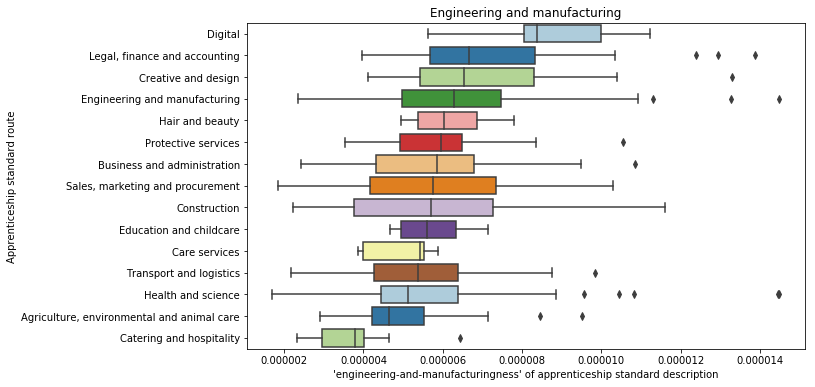

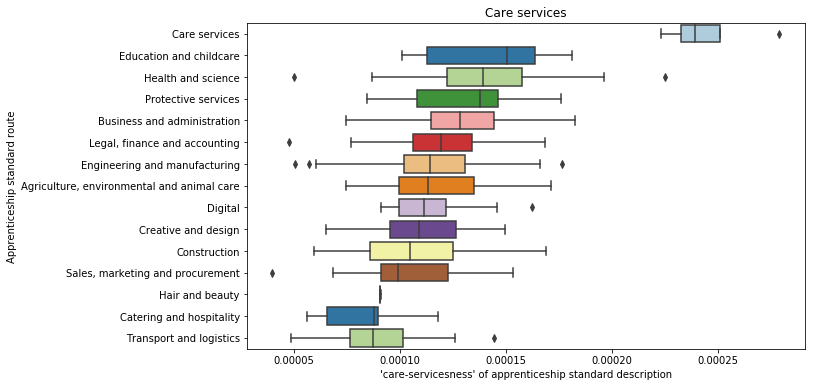

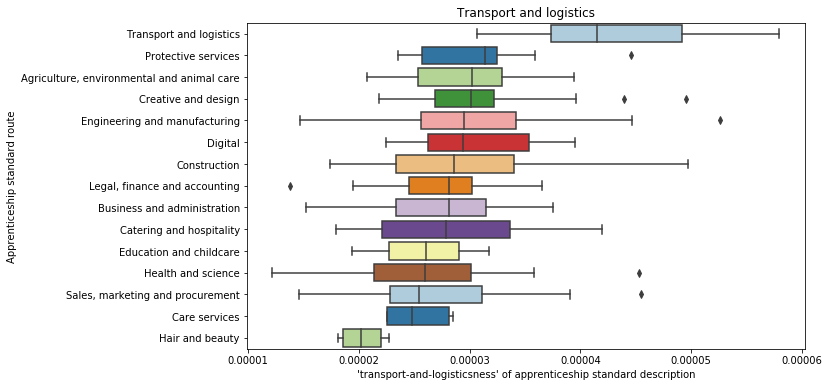

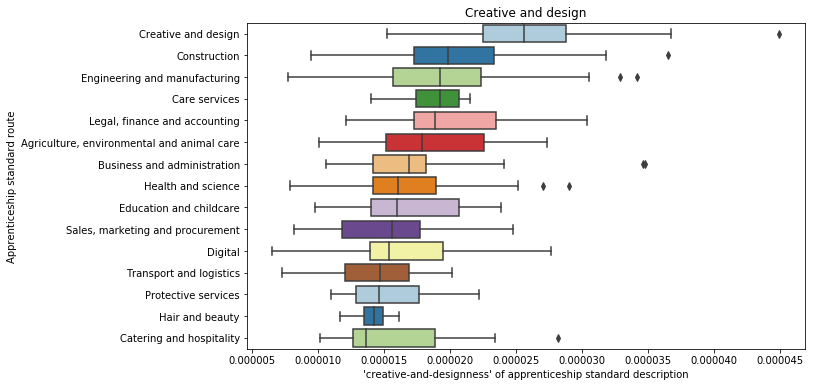

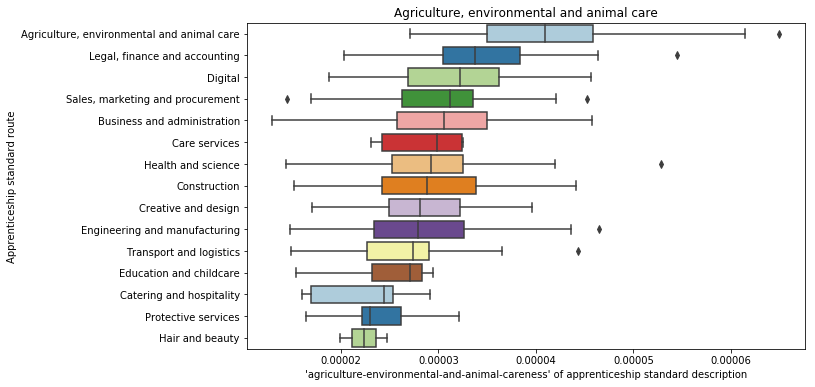

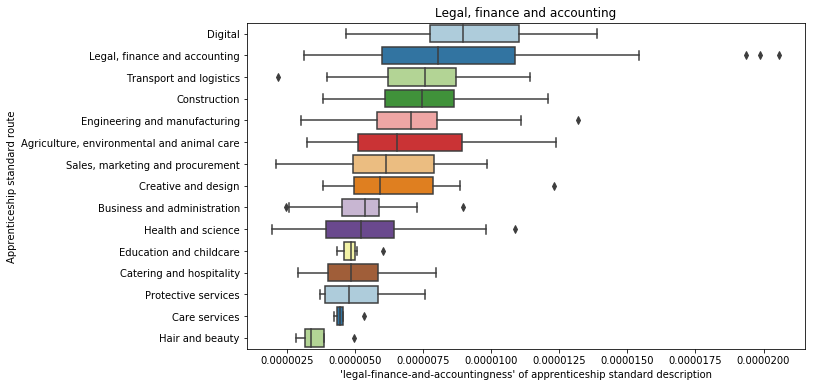

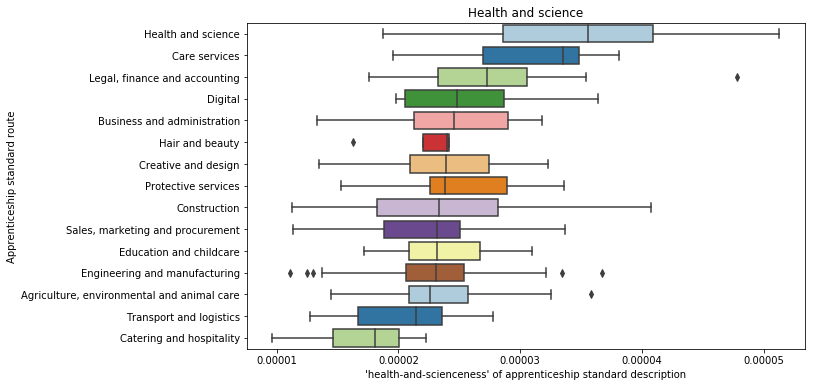

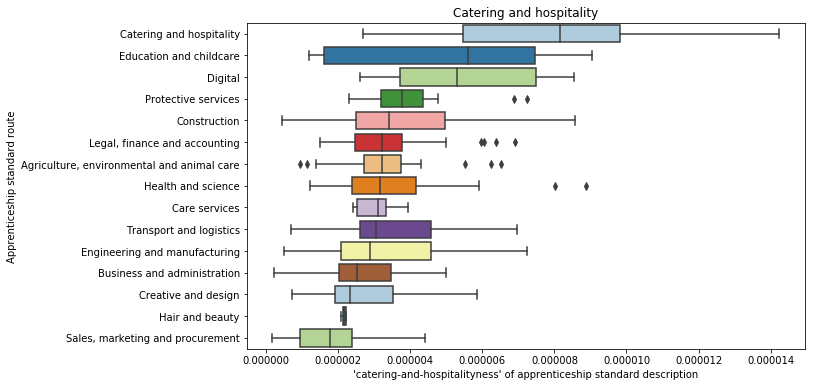

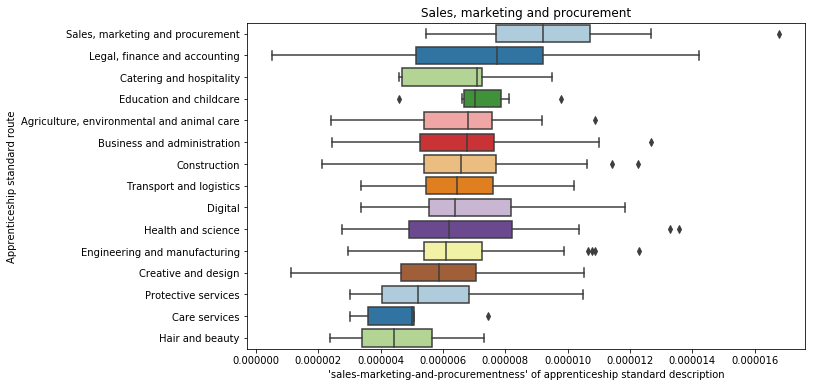

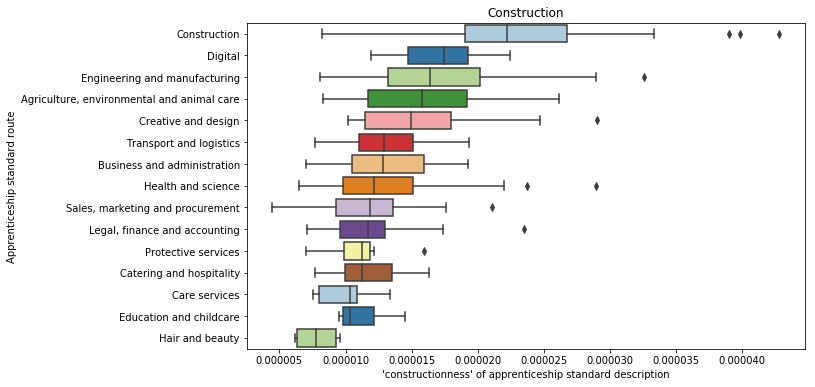

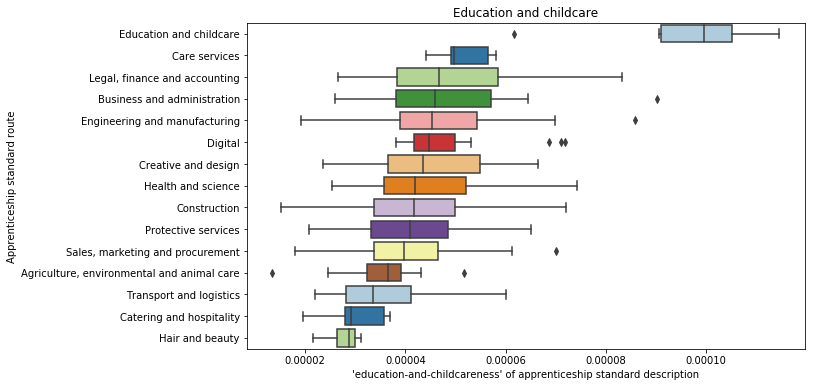

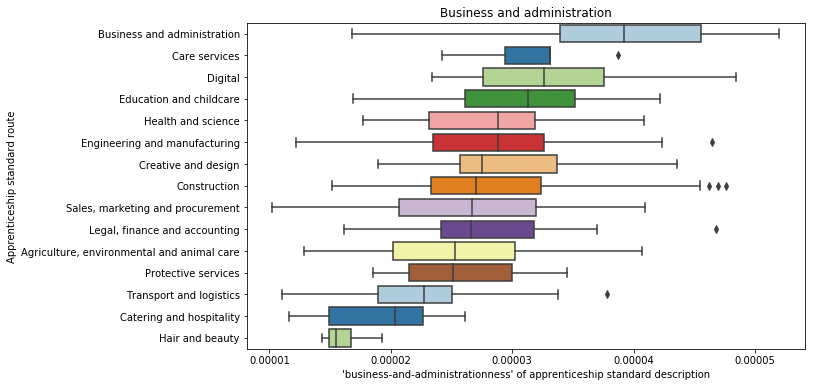

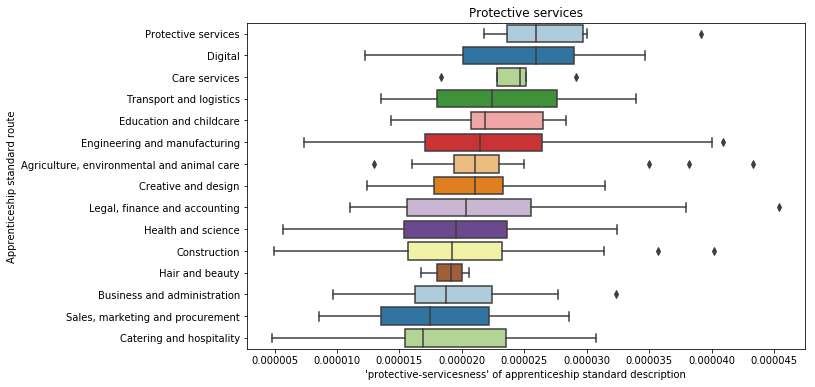

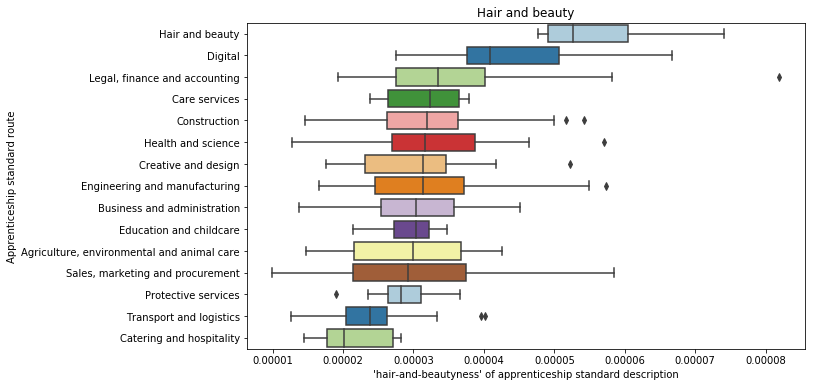

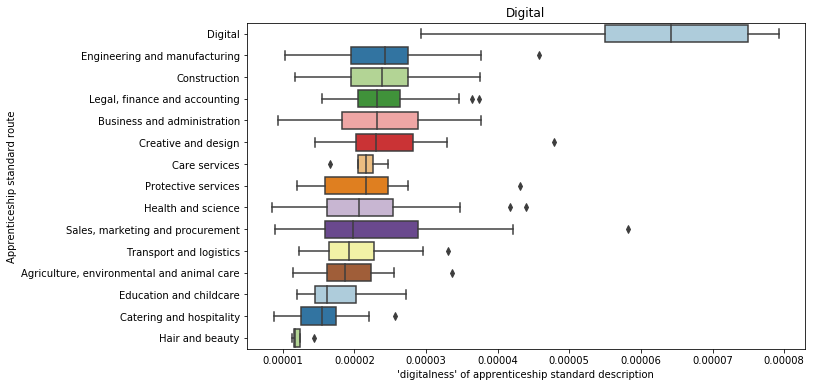

In [80]:
features = bin_vec.get_feature_names()
    
importances = {}
scores = {}
out_data = {}
unimportances = {}
for route in set(df_api.Route):
    print(route)
#    if route == 'Digital':
    keywords, keywords_unimportant = get_predictive_terms(df_api, bin_data, features, route, n=50)

    importances[route] = keywords
    unimportances[route] = keywords_unimportant
    count_vec = CountVectorizer(vocabulary=keywords.keys(), stop_words=new_stopwords)
    count_data = count_vec.fit_transform(textfortoken).toarray()

    weighted_count = []
    for _, row in pd.DataFrame(count_data, columns=count_vec.get_feature_names()).iterrows():
        wc = sum(np.log(count + 1)*importances[route][term] for term, count in row.iteritems() if count > 0)
        weighted_count.append(wc)
    weighted_count = np.array(weighted_count)

    #count_data[count_data > 0] = 1

    corpus_length = np.array([len(doc) for doc in textfortoken])
    digitalness = weighted_count/corpus_length

    _df = df_api.copy()
    _df[route] = digitalness #- np.median(digitalness)

    approved = _df.Status == "Approved for delivery"


    score = {group: grouped[route].median()
              for group, grouped in _df[approved].groupby("Route")}
    order = [route for route, score in Counter(score).most_common()]
    scores[route] = score

    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.boxplot(x=route, y="Route", 
                     data=_df[_df.Status == "Approved for delivery"], 
                     orient="h", order=order,
                     palette="Paired", ax=ax)

    ax.set_xlabel(f"'{route.replace(' ','-').replace(',','').lower()}ness' of apprenticeship standard description")
    ax.set_ylabel("Apprenticeship standard route")
    #ax.set_xlim(-0.003, 0.01)
    ax.set_title(route)
    plt.savefig(f"{route}-{int(stop_pc*100)}.png", bbox_inches = "tight")        

    out_data[route] = _df
    out_data[route].sort_values(route, ascending=False)[["Title", "Route", route]].to_csv(f"{route.replace(' ','-').replace(',','').lower()}ness-{int(stop_pc*100)}.csv", index=False)

print()
for route, imps in importances.items():
    print(route, "-->", [k for k, v in Counter(imps).most_common(20)])
    print()

print([out_data, scores, importances, unimportances, stop_words])

Text(0.5, 1.0, 'Engineering and manufacturing')

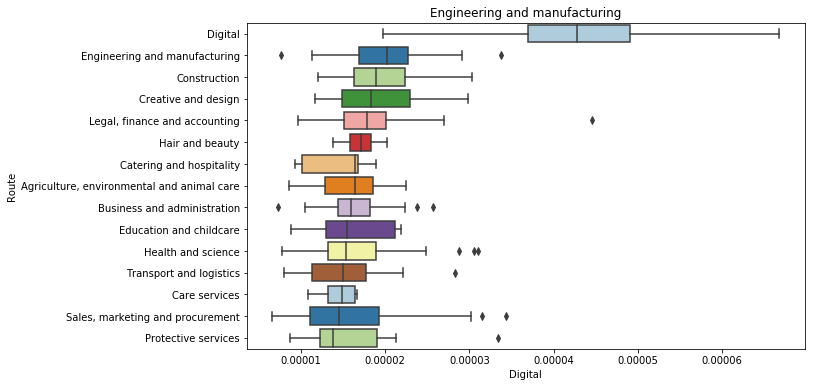

In [79]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x='Digital', y="Route", 
                 data=_df[_df.Status == "Approved for delivery"], 
                 orient="h", order=order,
                 palette="Paired", ax=ax)

#ax.set_xlabel(f"'{route.replace(' ','-').replace(',','').lower()}ness' of apprenticeship standard description")
#ax.set_ylabel("Apprenticeship standard route")
#ax.set_xlim(-0.003, 0.01)
ax.set_title(route)
#plt.savefig(f"figs/language_specialisation/{route}-{int(stop_pc*100)}.png", bbox_inches = "tight")        
